# 0. 초기 세팅

In [ ]:
import random
import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
#load all the libraries...
import pandas as pd
import numpy as np
import re
from IPython.display import display, HTML, Image

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
import os
os.chdir('/content/drive/MyDrive/LGAIMER')

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
CFG = {
    'TRAIN_WINDOW_SIZE':90, # 90일치로 학습
    'PREDICT_SIZE':21, # 21일치 예측
    'EPOCHS':10,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':512,
    'SEED':41
}

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

# 1. 라벨 인코딩

In [ ]:
train_data = pd.read_csv('data/train.csv').drop(columns=['ID', '제품'])
sales = pd.read_csv('data/sales.csv').drop(columns=['ID', '제품'])
brand_keyword_count = pd.read_csv('data/brand_keyword_cnt.csv')

In [ ]:
# 결측치 확인
# brand_keyword_count.isnull().sum()
NoneRow = (brand_keyword_count[brand_keyword_count.isnull().any(axis=1)]).loc[:, '브랜드']
NoneRow = list(NoneRow)

In [ ]:
NoneBrandIndex = []
for brandCode in NoneRow:
    NoneBrandIndex += list(train_data[train_data['브랜드'] == brandCode].index)

In [ ]:
len(NoneBrandIndex)

208

In [ ]:
brand_keyword_count = brand_keyword_count.dropna() # 결측치 제거 (35행 지워짐)
train_data = train_data.drop(NoneBrandIndex)
sales = sales.drop(NoneBrandIndex)

In [ ]:
train_data = train_data.rename(index = {j: i for i, j in enumerate(train_data.index)})
sales = sales.rename(index = {j: i for i, j in enumerate(sales.index)})

In [ ]:
# Label Encoding
label_encoder = LabelEncoder()
categorical_columns = ['대분류', '중분류', '소분류', '브랜드']

label_encoder.fit(brand_keyword_count['브랜드'])
brand_keyword_count['브랜드'] = label_encoder.transform(brand_keyword_count['브랜드'])

for col in categorical_columns:
    label_encoder.fit(train_data[col])
    train_data[col] = label_encoder.transform(train_data[col])

    label_encoder.fit(sales[col])
    sales[col] = label_encoder.transform(sales[col])

In [ ]:
train_data_date = train_data.iloc[:, 4:]
train_data_class = train_data.iloc[:, :4]

tmp_date = train_data_date.replace(0, 1)
prices = sales.iloc[:, 4:] / tmp_date

In [ ]:
train_data = train_data                                                     # sale count 판매량
sales = sales                                                               # sale 총 판매금액
brand_keyword_count = brand_keyword_count                                   # brand keyword count 브랜드 키워드량
prices = pd.concat([train_data.iloc[:, :4], prices], axis = 1)              # price 가격

# 2. 데이터 그래프

## 2-1. 일별 판매량

같은 `Brand Number` 에 대해서 `sale count` 판매량 비교

In [ ]:
def same_col_data(id, data, col='브랜드'):
    same_col_data = data[data[col] == id]
    len_row = len(same_col_data)
    X = same_col_data.iloc[0, :][4:].index
    y = [same_col_data.iloc[i, :][4:] for i in range(len_row)]
    return X, y

In [ ]:
id = 1
X, y = same_col_data(id, train_data)

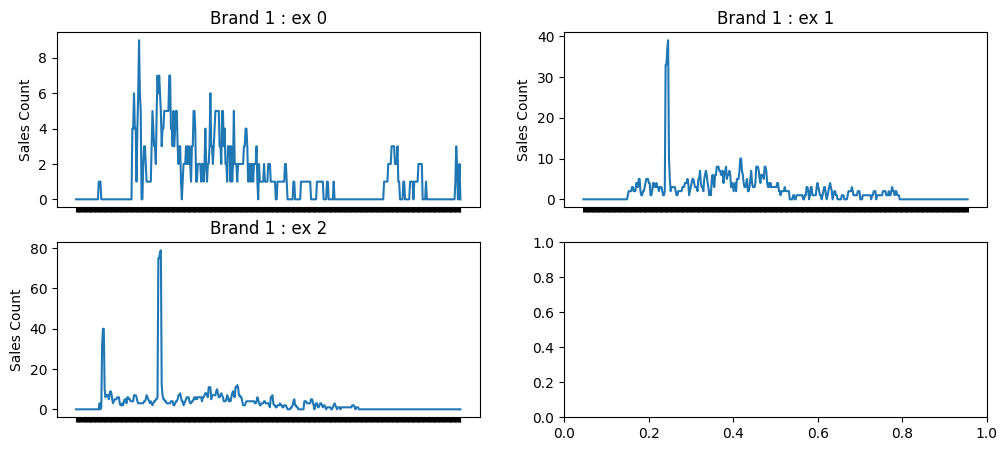

In [ ]:
rows = math.ceil(len(y) / 2)
fig, ax = plt.subplots(rows, 2, figsize=(12, 5))

count = 0
for row in range(rows):
    for col in range(2):
        ax[row][col].plot(X, y[count])
        ax[row][col].set_title(f"Brand {id} : ex {count}")
        ax[row][col].set_ylabel('Sales Count')
        # ax[row][col].set_xticks([])
        ax[row][col].set_xticklabels([])
        count += 1
        if count == len(y):
            break

plt.show()

`Sales Count`, `Price`, `Brand Keyword Count` 에 대해서 데이터 비교

In [ ]:
def one_row_data(id, salecount_data, price_data, brand_data):
    one_row_data = salecount_data.iloc[id, 4:]
    brand_id = salecount_data.loc[id, '브랜드']

    X = one_row_data.index
    y_salecount = one_row_data
    y_price = price_data.iloc[id, 4:]
    y_brand = brand_data[brand_data['브랜드'] == brand_id].iloc[0, 1:]
    return X, y_salecount, y_price, y_brand

In [ ]:
id = 1
X, y_salecount, y_price, y_brand = one_row_data(id, train_data, prices, brand_keyword_count)

In [ ]:
# 표준화
mean_price = np.mean(y_price)
std_price = np.std(y_price)
y_price_ = (y_price - mean_price) / std_price

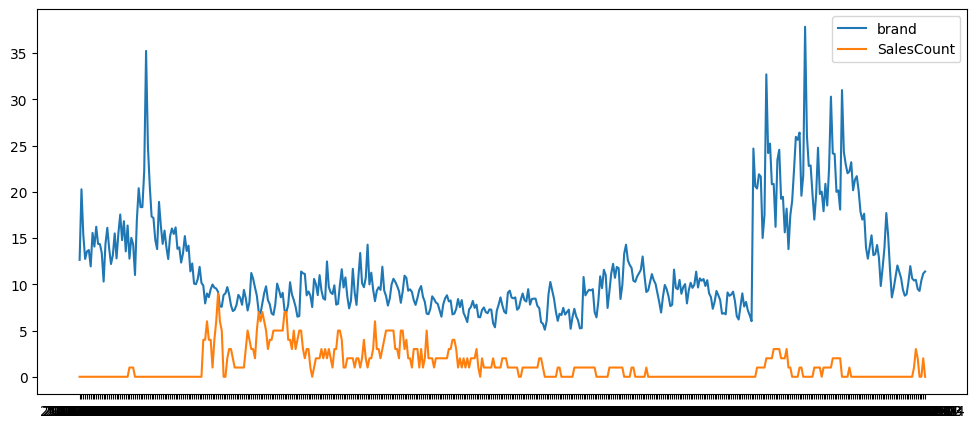

In [ ]:
plt.figure(figsize=(12,5))
# plt.yscale('linear') # 'linear', 'log', 'symlog', 'asinh', 'logit', 'function', 'functionlog'
# plt.plot(X, y_price_, label = 'Prices')
plt.plot(X, y_brand, label = 'brand')
plt.plot(X, y_salecount, label = 'SalesCount')

plt.legend()

# 3. 인과관계 존재여부 확인

## 3-1. 모델 학습

`독립변수 x (Brand)` 가 `종속변수 y (Sale Count)` 에 영향을 주는지 확인한다.

ols 모델은 Linear Regression 모델 이다.

In [ ]:
from statsmodels.formula.api import ols

In [ ]:
X_brand = pd.DataFrame(y_brand)
y_salecount = pd.DataFrame(y_salecount)

In [ ]:
X_brand = X_brand.rename(columns={X_brand.columns[0]:'brand'}).astype({'brand':'float'})
y_salecount = y_salecount.rename(columns={y_salecount.columns[0]:'salecount'}).astype({'salecount':'float'})

In [ ]:
check_relation_data = pd.concat([y_salecount, X_brand], axis=1) # [결과, 원인]

In [ ]:
ls_model = ols("salecount ~ brand", data=check_relation_data).fit() # 결과 칼럼 ~ 원인 칼럼
print(ls_model.summary())

                            OLS Regression Results                            
Dep. Variable:              salecount   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     30.70
Date:                Mon, 14 Aug 2023   Prob (F-statistic):           5.10e-08
Time:                        09:46:49   Log-Likelihood:                -868.99
No. Observations:                 459   AIC:                             1742.
Df Residuals:                     457   BIC:                             1750.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2089      0.184     12.034      0.0

1. `t_score`: 결과의 중요성을 나타내는 t-stats와 같습니다. 0에 가까울수록 의미가 없을 가능성이 높습니다. 긍정적이든 부정적이든 t-통계가 클수록 결과의 중요성이 커집니다.
2. `coefficient_pvalue`: 앞서 언급했듯이 계수가 0(영향 없음)과 같다는 귀무 가설을 테스트합니다. 낮은 p-값(< 0.05)은 귀무 가설을 기각할 수 있음을 나타냅니다.
3. `기울기(계수)`: 선의 두 지점 사이의 "판매량 변화"에 대한 "가격 변화"의 비율입니다.
4. `price_mean`: 제품당 평균 가격
5. `quantity_mean`: 제품당 판매된 평균 수량
6. `intercept 절편`: 다른 모든 변수가 0일 때 X의 양과 같음
7. `R-Squared` : 결정계수의 값은 0에서 1 사이에 있으며, 종속 변인과 독립변인 사이에 상관관계가 높을수록 1에 가까워진다. 즉, 결정계수가 0에 가까운 값을 가지는 회귀모형은 유용성이 낮은 반면, 결정계수의 값이 클수록 회귀모형의 유용성이 높다고 할 수 있다.

`결과 해석`

작은 P-값(0.000)은 브랜드키워드량이 판매 수량에 영향을 미치지 않는다는 귀무가설을 귀각할 수 있음을 보여줍니다. (즉, 영향을 미친다.)

위 결과에서는, R-squared 가 0.063이므로 **brand** 가 **salecount** 에 대해 6.3% 만큼 설명한다.

## 3-2. 모델 관찰

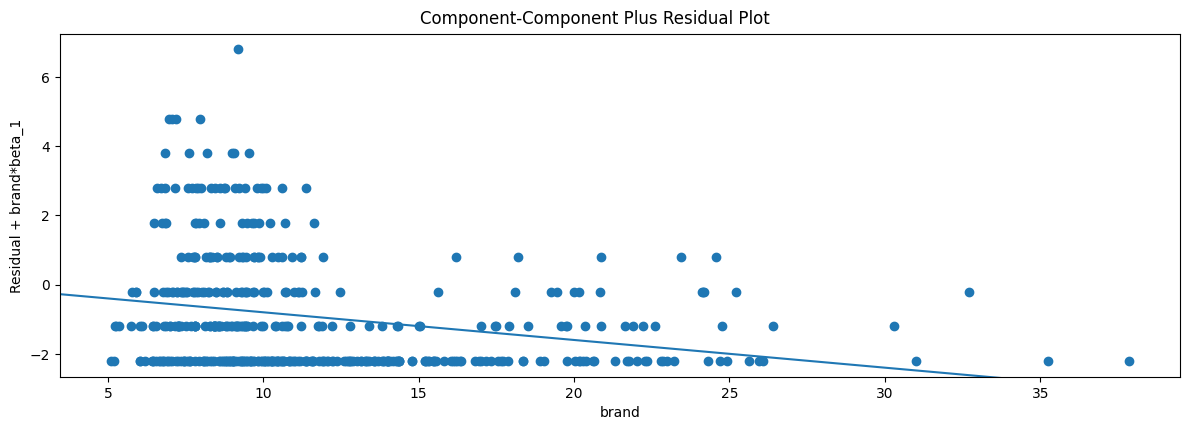

In [ ]:
fig = plt.figure(figsize=(12, 8))
fig = sm.graphics.plot_ccpr_grid(ls_model, fig=fig)

일부 회귀선에 가까우나, 일부 데이터 포인트는 떨어져 있다. 따라서, 예측이 그다지 정확하지 않을 수 있다.

# 4. 수요의 브랜드탄력성

## 4-1. 수요의 브랜드 탄력성 구하기

`수요 (y)` 의 `가격 (X) 탄력성` | 수요의 가격탄력성은 가격의 백분율 변화에 대한 수요의 상대적 백분율 변화를 측정한다.

`수요 (y)`의 `브랜드 (X) 탄력성` | **수요의 브랜드탄력성은 브랜드카운트의 백분율 변화에 대한 수요의 상대적 백분율 변화를 측정한다.**

In [ ]:
points = []
results_values = {
    "name": [],
    "brand_elasticity": [],
    "brand_mean": [],
    "scalecount_mean": [],
    "intercept": [],
    "t_score":[],
    "slope": [],
    "coefficient_pvalue" : [],
}

In [ ]:
def data_for_ols(y_brand, y_salecount):
    X_brand = pd.DataFrame(y_brand)
    y_salecount = pd.DataFrame(y_salecount)

    X_brand = X_brand.rename(columns={X_brand.columns[0]:'brand'}).astype({'brand':'float'})
    y_salecount = y_salecount.rename(columns={y_salecount.columns[0]:'salecount'}).astype({'salecount':'float'})

    check_relation_data = pd.concat([y_salecount, X_brand], axis=1) # [결과, 원인]
    return check_relation_data

In [ ]:
for row in tqdm(range(len(train_data))):

    #Linear Regression Model
    _, y_salecount, _, y_brand = one_row_data(row, train_data, prices, brand_keyword_count)
    check_relation_data = data_for_ols(y_brand, y_salecount)
    ls_model = ols("salecount ~ brand", data=check_relation_data).fit() # 결과 칼럼 ~ 원인 칼럼

    #(Null Hypothesis test) Coefficient with a p value less than 0.05
    if ls_model.f_pvalue < 0.05:

        rsquared = ls_model.rsquared
        coefficient_pvalue = ls_model.f_pvalue
        intercept, slope = ls_model.params
        mean_brand = np.mean(y_brand)
        mean_scalecount = np.mean(y_salecount)
        tintercept, t_score = ls_model.tvalues

        #Brand elasticity Formula
        brand_elasticity = (slope)*(mean_brand/mean_scalecount)

        #Append results into dictionary for dataframe
        results_values["name"].append(row)
        results_values["brand_elasticity"].append(brand_elasticity)
        results_values["brand_mean"].append(mean_brand)
        results_values["scalecount_mean"].append(mean_scalecount)
        results_values["intercept"].append(intercept)
        results_values['t_score'].append(t_score)
        results_values["slope"].append(slope)
        results_values["coefficient_pvalue"].append(coefficient_pvalue)

  0%|          | 0/15682 [00:00<?, ?it/s]

In [ ]:
final_df = pd.DataFrame.from_dict(results_values)
df_elasticity = final_df[['name','brand_elasticity','t_score','coefficient_pvalue','slope','brand_mean','scalecount_mean','intercept']]
df_elasticity

,name,brand_elasticity,t_score,coefficient_pvalue,slope,brand_mean,scalecount_mean,intercept
0,1,-0.724281,-5.540501,5.101528e-08,-0.079918,11.609882,1.281046,2.208883
1,2,-1.128183,-6.744576,4.652528e-11,-0.219542,11.609882,2.259259,4.808118
2,3,-0.579339,-2.444688,1.487452e-02,-0.172641,11.609882,3.459695,5.464032
3,17,-0.647602,-2.821516,4.987979e-03,-3.382542,1.879088,9.814815,16.170908
4,22,1.016223,4.932701,1.137520e-06,0.444192,1.879088,0.821351,-0.013325
...,...,...,...,...,...,...,...,...
5110,15652,0.140945,2.592206,9.841711e-03,4.640755,0.147356,4.851852,4.168009
5111,15661,-0.389008,-2.735006,6.480486e-03,-11.836505,0.147356,4.483660,6.227840
5112,15676,-3.116444,-2.318062,2.088661e-02,-0.018491,5.507831,0.032680,0.134524
5113,15677,-1.237736,-2.783228,5.605159e-03,-2.873908,5.507831,12.788671,28.617673


0~1 : 비탄력적.

0↓ : 브랜드 하락 - 판매 수요 증가 (가능성)

0↑ : 브랜드 상승 - 판매 수요 증가 (가능성)

## 4-2. 1보다 큰 브랜드 탄력성에 대해서 제품 확인

In [ ]:
train_data_contain_info = pd.read_csv("data/train.csv").drop(NoneBrandIndex)
train_data_contain_info = train_data_contain_info.rename(index = {j: i for i, j in enumerate(train_data_contain_info.index)})
train_data_contain_info = train_data_contain_info.drop(columns=['ID'])

In [ ]:
product_info = pd.read_csv("data/product_info.csv")

In [ ]:
df_elasticity[df_elasticity['brand_elasticity'] > 1]

,name,brand_elasticity,t_score,coefficient_pvalue,slope,brand_mean,scalecount_mean,intercept
4,22,1.016223,4.932701,1.137520e-06,0.444192,1.879088,0.821351,-0.013325
5,23,3.659625,6.711816,5.709872e-11,1.188050,1.879088,0.610022,-1.622429
8,37,2.643406,14.893413,3.536132e-41,0.033165,51.747954,0.649237,-1.066961
18,77,1.201108,2.571246,1.044856e-02,0.091605,5.170447,0.394336,-0.079304
22,88,1.168547,4.959733,9.971314e-07,0.047171,1.673092,0.067538,-0.011383
...,...,...,...,...,...,...,...,...
5078,15460,7.756587,5.461131,7.781399e-08,0.088096,0.959119,0.010893,-0.073601
5079,15473,1.006558,5.854472,9.147527e-09,32.591072,8.605061,278.620915,-1.827233
5091,15516,6.034358,9.192638,1.357972e-18,30.243366,9.135627,45.786492,-230.505610
5100,15587,1.978502,2.056034,4.034666e-02,0.009416,9.156018,0.043573,-0.042636


In [ ]:
product_info[product_info['제품'] == train_data_contain_info.loc[7265, '제품']]

,제품,제품특성
11271,B002-01807-00003,피부타입:모든피부용 주요제품특징:촉촉함(수분공급) 용기형태:튜브형 용량:35ml(g...


## 4-3. 브랜드 탄력성 랭킹

In [ ]:
values_column = 'brand_elasticity'
ylabel = 'Ranking Number'
xlabel = 'Brand Elasticity'
df = df_elasticity

In [ ]:
df['ranking'] = df[values_column].rank(ascending = True).astype(int)
df.sort_values(values_column, ascending =False, inplace = True)

#Adjust Ranking column and print dataframe
pd.set_option('display.width', 4000)
cols = list(df.columns)
cols = [cols[-1]] + cols[:-1]
df = df[cols]

df = df.iloc[:,:3]
df.set_index('ranking', inplace=True)
display(df)

,name,brand_elasticity
ranking,,
5115,7265,17.686519
5114,10164,12.623280
5113,8680,12.118606
5112,13210,8.832632
5111,10162,8.809731
...,...,...
5,6901,-6.337749
4,4717,-7.431976
3,9851,-7.591535
